In [2]:
from flakylib import *
import math
import numpy as np
import numba as nb
from numba import prange
import matplotlib.pyplot as plt

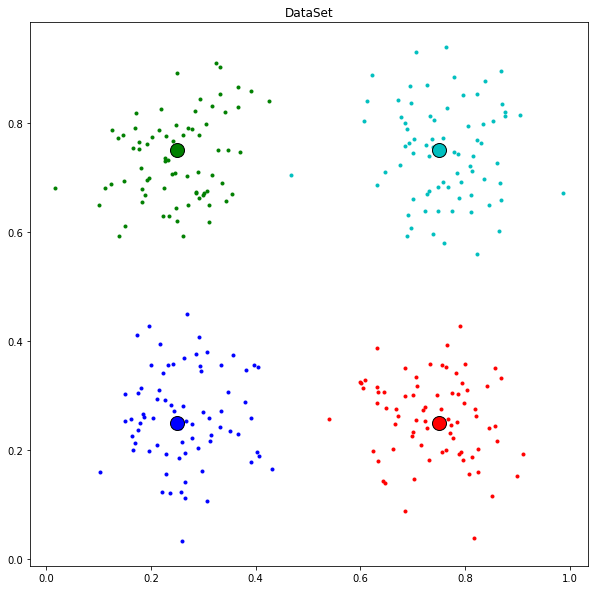

In [22]:
grid_size = 2
n_features = 2
n_samples = 300
standard_deviation = 0.08
n_candidates = 3

samples, true_sample_membership, true_centroids = generate_blobs_on_grid(n_samples, grid_size, n_features, standard_deviation)

if n_features == 2:
    draw_dataset(samples, true_centroids, true_sample_membership)
    
n_samples = samples.shape[0]
true_n_clusters = true_centroids.shape[0]



In [23]:
%%time
n_clusters, cluster_nums, drop_rates, objectives = number_of_clusters(samples, min_num = 2, max_num = 20)

print('Computed number of clusters: ', n_clusters)
print('True number of clusters: ', true_n_clusters)
print('')

Computed number of clusters:  4
True number of clusters:  4

CPU times: user 1.67 s, sys: 48 ms, total: 1.72 s
Wall time: 378 ms


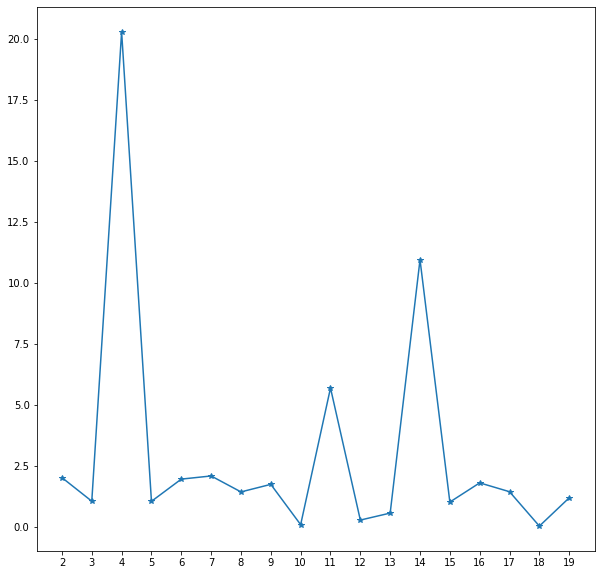

In [24]:
plt.xticks(np.arange(min(cluster_nums), max(cluster_nums)+1, 1.0))
plt.plot(cluster_nums, drop_rates, '-*')
plt.show()